In [1]:
"""
Created on Wed Jan 10 17:13:16 2024
@author: Wu Yuxuan
"""

import os
import warnings

from gseapy import Msigdb
import decoupler as dc
import gseapy as gp
from gseapy import barplot, dotplot
import scFates as scf
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import numpy as np
from matplotlib import rc_context
from adjustText import adjust_text
from matplotlib import pyplot as plt
from ridgeplot import ridgeplot

import cellrank as cr
# import scanpy as sc
import scvelo as scv

from statannotations.Annotator import Annotator

In [2]:
seed = 1
warnings.simplefilter(action='ignore', category=FutureWarning)
# info
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(vector_friendly=True, dpi_save=1200) 
sc.logging.print_header()

scanpy==0.1.dev3254+g5b9bc72 anndata==0.10.3 umap==0.5.5 numpy==1.26.0 scipy==1.11.3 pandas==1.5.2 scikit-learn==1.1.3 statsmodels==0.14.0 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


In [3]:
os.chdir('/home/wu/datb1/reseq_ppp/Pub_PPP_code')

In [4]:
sns.set_style("white")

In [5]:
adata_immu = sc.read_h5ad('/home/wu/datb1/reseq_ppp/processed_data/IMMU_PPP_10X.h5ad')

In [6]:
adata_immu.uns['leiden_colors'][0] = '#d62728'
adata_immu.uns['leiden_colors'][3] = '#1f77b4'

In [7]:
adata_immu.obs['batch_group'] = adata_immu.obs.batch_group.cat.reorder_categories(['HC', 'NL', 'Lesion'])
adata_immu.uns['batch_group_colors'] = ['#3182bd', '#31a354', '#fd8d3c']

In [8]:
adata_immu.obs.leiden.cat.categories

Index(['CD8+ T cell', 'Classical dendritic cell', 'Helper T cell',
       'INHBA+ Macrophage', 'Langerhans cell', 'Macrophage', 'Mast cell',
       'PPP neutrophil', 'Plasmacytoid dendritic cell', 'Regulatory T cell'],
      dtype='object')

### pseudo bulk

In [9]:
pdata = dc.get_pseudobulk(
    adata_immu,
    sample_col='batch',
    groups_col='leiden',
    layer='counts',
    mode='sum',
    min_cells=50,
    min_counts=1000
)

In [10]:
pdata_neutrophil = pdata[pdata.obs.leiden.isin(['PPP neutrophil'])].copy()

### Add external data

In [11]:
bulk_df_extracted = pd.read_csv('/home/wu/datb1/reseq_ppp/E-MTAB-11190_normal_bulk_neut/03.count/bulk_neut_rna.csv')
bulk_df_extracted = bulk_df_extracted.groupby('gene_symbol').sum()
bulk_df_extracted = bulk_df_extracted[bulk_df_extracted.index.isin(pdata_neutrophil.var_names)]
pdata_normal_bulk_neut = ad.AnnData(X=bulk_df_extracted.T)
pdata_neut_merge = ad.concat([pdata_neutrophil, pdata_normal_bulk_neut], join='inner')
pdata_neut_merge = pdata_neut_merge[pdata_neut_merge.obs.index.str.contains('PPP_|ERR')].copy()
pdata_neut_merge.obs['group'] = pdata_neut_merge.obs.index.map(lambda x: 'PPP' if 'PPP' in x else 'HC')
pdata_neut_merge.X = pdata_neut_merge.X.astype(np.float32)

In [12]:
pdata_merge = ad.concat([pdata, pdata_normal_bulk_neut], join='inner')
pdata_merge.obs['leiden'] = list(pdata.obs.leiden.astype(str)) + ['Neutrophil']*8
pdata_merge.obs['batch_group'] = list(pdata.obs.batch_group.astype(str)) + ['HC']*8

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata_merge, target_sum=1e4)
sc.pp.log1p(pdata_merge)
sc.pp.scale(pdata_merge, max_value=10)
sc.tl.pca(pdata_merge)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)


In [13]:
pdata.obs.leiden
pdata_merge.obs['OSM_exp'] = pdata_merge[:, 'OSM'].X.toarray().flatten()

In [14]:
pdata_merge.obs[pdata_merge.obs.leiden == 'PPP neutrophil']

,leiden,batch_group,OSM_exp
PPP_P16_foot_10X_PPP neutrophil,PPP neutrophil,Lesion,2.139272
PPP_P17_palm_10X_PPP neutrophil,PPP neutrophil,Lesion,1.315909
PPP_P36_foot_10X_PPP neutrophil,PPP neutrophil,Lesion,3.040485
PPP_P37_palm_10X_PPP neutrophil,PPP neutrophil,Lesion,2.806004
PPP_P38_palm_10X_PPP neutrophil,PPP neutrophil,Lesion,2.801322
PPP_P39_palm_10X_PPP neutrophil,PPP neutrophil,Lesion,2.622988
PPP_P40_palm_10X_PPP neutrophil,PPP neutrophil,Lesion,2.206961


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Neutrophil vs. PPP neutrophil: Mann-Whitney-Wilcoxon test two-sided, P_val:2.051e-02 U_stat=8.000e+00


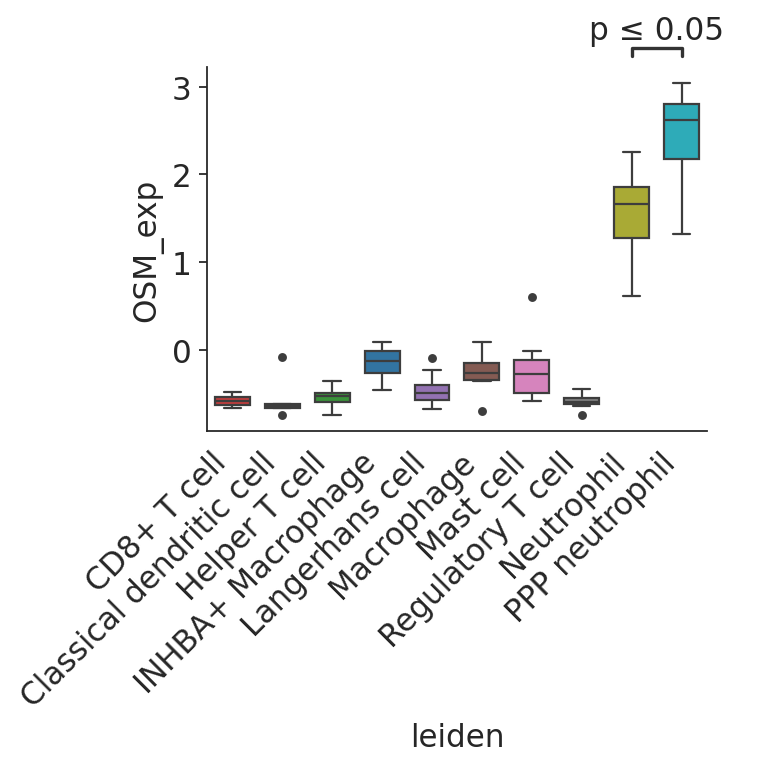

In [15]:
with rc_context({'figure.figsize': (4, 3)}):
    order = list(pdata_merge.obs.leiden.unique())
    order.remove('Neutrophil')
    order.remove('PPP neutrophil')
    order = order + ['Neutrophil', 'PPP neutrophil']
    g = sns.boxplot(data=pdata_merge.obs, x='leiden', y='OSM_exp', flierprops={"marker": "o", "alpha": 1, "markersize": 3}, palette=sns.palettes.color_palette((adata_immu.uns['leiden_colors'])), \
        order=order, width=0.7, linewidth=1)
    g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g.yaxis.set_ticks_position('left')

    sns.despine()
    pairs = [('Neutrophil', 'PPP neutrophil')]

    annotator = Annotator(g, pairs=pairs, data=pdata_merge.obs, x='leiden', y='OSM_exp', order=order)
    annotator.configure(test="Mann-Whitney", text_format='simple', loc='outside', show_test_name=False)
    annotator.apply_and_annotate()
    
    plt.savefig('figures/fig4_2/OSM_exp_in_neutrophil.pdf', bbox_inches='tight')

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


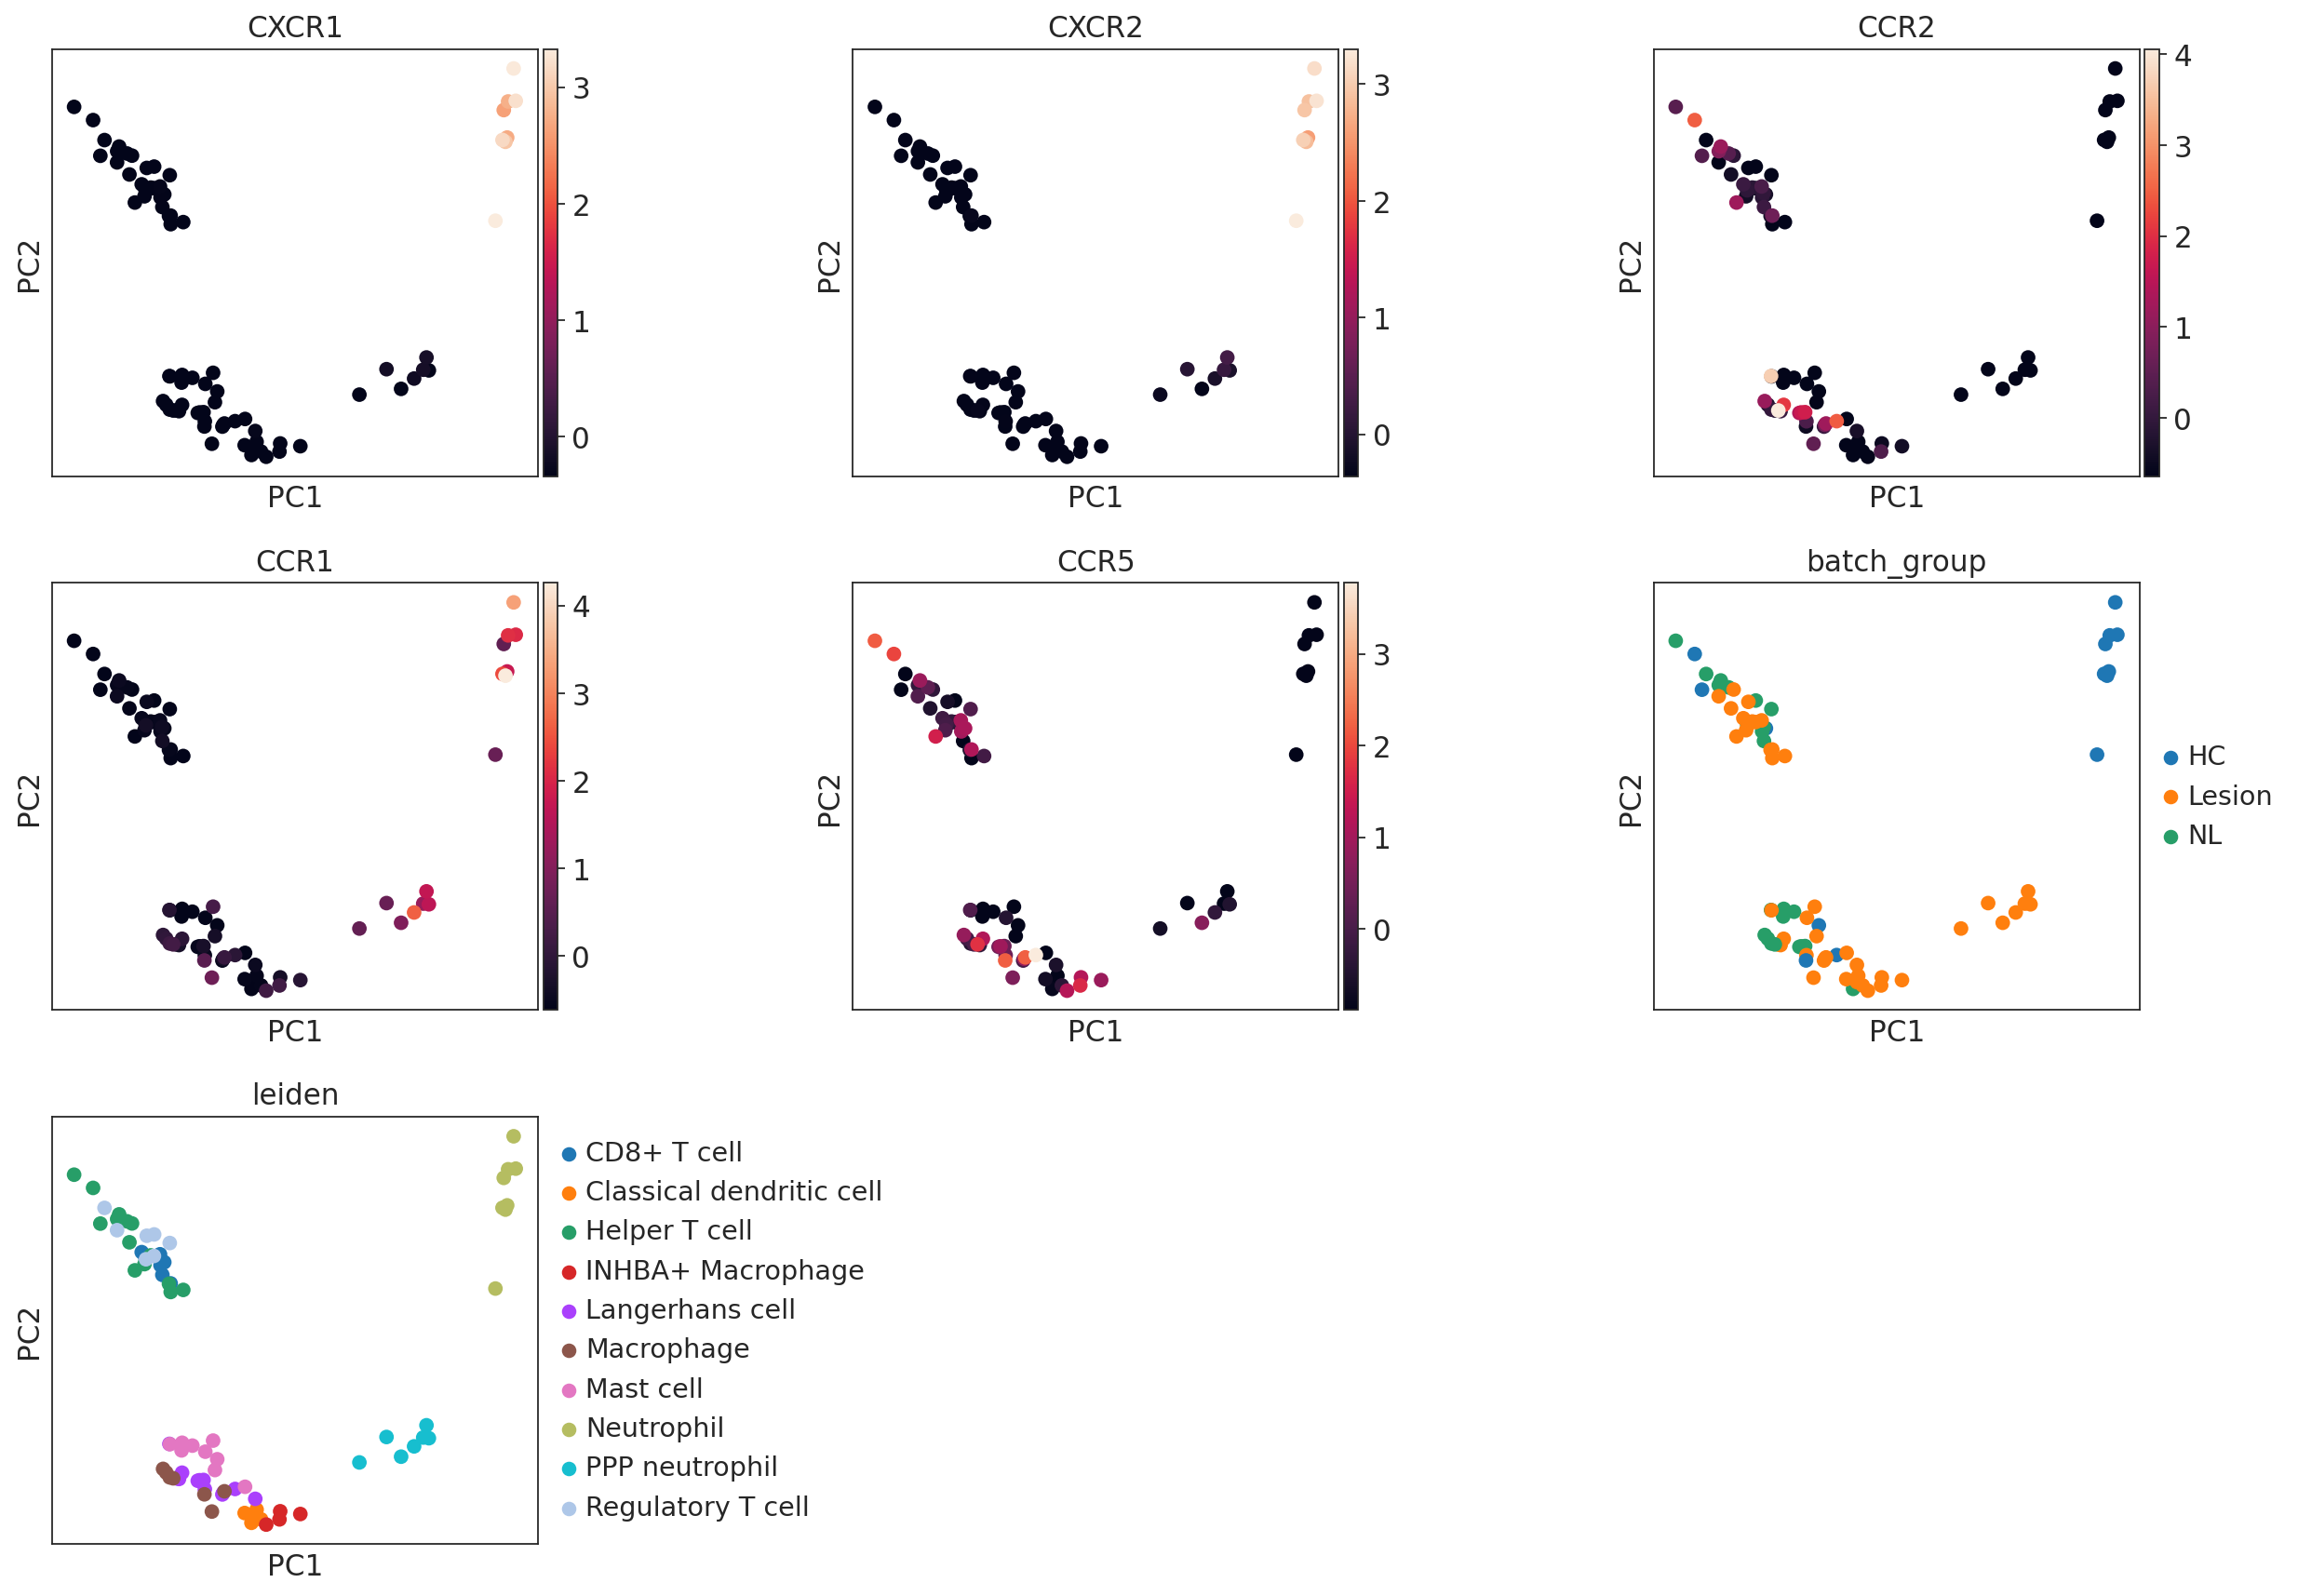

In [19]:
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.pca(pdata_merge, color=['CXCR1', 'CXCR2', 'CCR2', 'CCR1', 'CCR5', 'batch_group', 'leiden'], ncols=3, wspace=0.5, size=200, show=False)

/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/wu/scanpy/scanpy/plotting/_tools/scatterplots.py:399: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


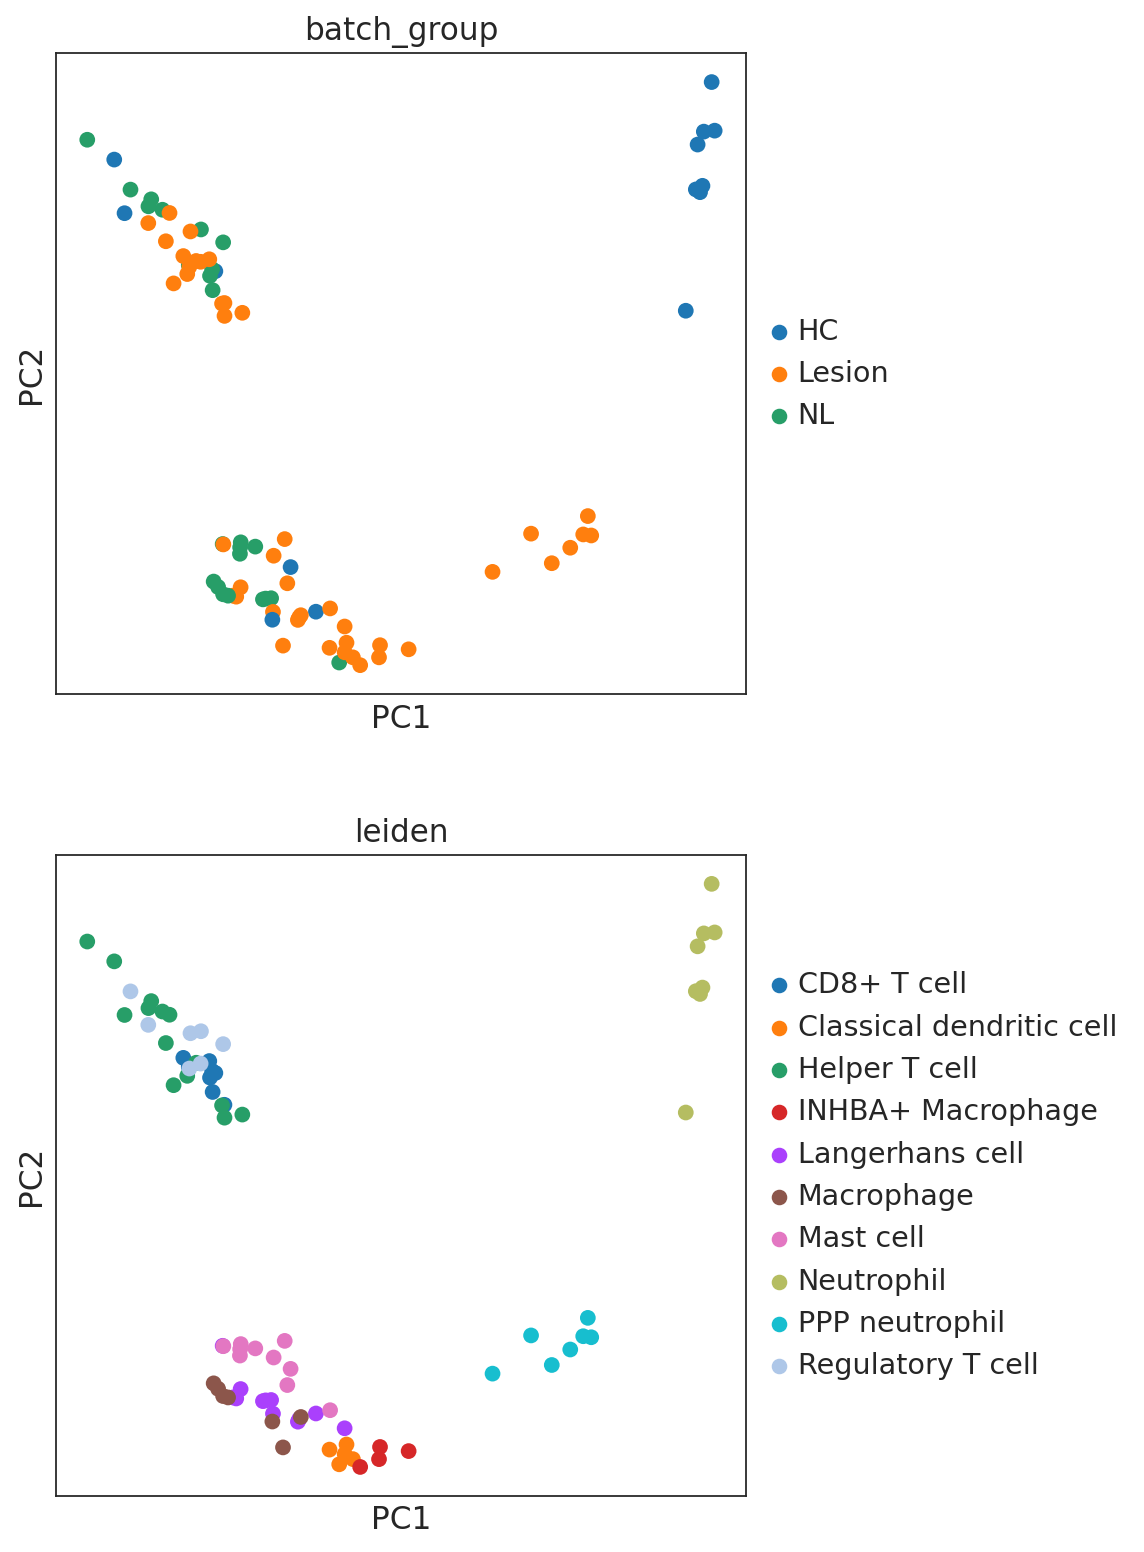

In [16]:
with rc_context({'figure.figsize': (4, 5.5)}):
    sc.pl.pca(pdata_merge, color=['batch_group', 'leiden'], ncols=1, wspace=0.5, size=200, show=False)
    plt.savefig('figures/fig4_2/merged_pseudo_pca.pdf', bbox_inches='tight')
    plt.show()

### Pseudo DE analysis

In [37]:
genes = dc.filter_by_expr(pdata_neut_merge, group='group', min_count=10, min_total_count=100)
pdata_neut_merge = pdata_neut_merge[:, genes].copy()
pdata_neut_merge

AnnData object with n_obs × n_vars = 15 × 7383
    obs: 'group'

In [38]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

In [39]:
# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=pdata_neut_merge,
    design_factors='group',
    ref_level=['group', 'PPP'],
    refit_cooks=True,
    inference=inference,
)

# Compute LFCs
dds.deseq2()

stat_res = DeseqStats(
    dds,
    contrast=["group", 'PPP', 'HC'],
    inference=inference,
)

# Compute Wald test
stat_res.summary()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 2.75 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 2.53 seconds.

Fitting LFCs...
... done in 1.08 seconds.

Replacing 70 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: group PPP vs HC
          baseMean  log2FoldChange     lfcSE      stat        pvalue      padj
AAAS      7.584111       -1.934376  0.824249 -2.346834  1.893370e-02  0.029392
AACS      8.161817       -0.493372  1.016996 -0.485127  6.275864e-01  0.681994
AAGAB    29.153942       -1.722383  0.477567 -3.606580  3.102597e-04  0.000645
AAK1     65.380470        1.017109  0.301698  3.371284  7.481877e-04  0.001475
AAMP     19.926750       -0.125500  0.560291 -0.223991  8.227643e-01  0.855198
...            ...             ...       ...       ...           ...       ...
ZSWIM8   42.788898        0.944775  0.299355  3.156032  1.599316e-03  0.002985
ZXDC     24.672031       -3.288705  0.649524 -5.063256  4.121561e-07  0.000001
ZYG11B   44.678600       -2.485301  0.604827 -4.109114  3.971797e-05  0.000094
ZYX     568.941772       -3.230675  0.843151 -3.831667  1.272780e-04  0.000280
ZZEF1    85.202873       -1.124394  0.342066 -3.287066  1.012370e-03  0.00195

... done in 0.22 seconds.



In [40]:
stat_res.results_df[['stat']]

,stat
AAAS,-2.346834
AACS,-0.485127
AAGAB,-3.606580
AAK1,3.371284
AAMP,-0.223991
...,...
ZSWIM8,3.156032
ZXDC,-5.063256
ZYG11B,-4.109114
ZYX,-3.831667


In [41]:
stat_res.results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AAAS,7.584111,-1.934376,0.824249,-2.346834,1.893370e-02,0.029392
AACS,8.161817,-0.493372,1.016996,-0.485127,6.275864e-01,0.681994
AAGAB,29.153942,-1.722383,0.477567,-3.606580,3.102597e-04,0.000645
AAK1,65.380470,1.017109,0.301698,3.371284,7.481877e-04,0.001475
AAMP,19.926750,-0.125500,0.560291,-0.223991,8.227643e-01,0.855198
...,...,...,...,...,...,...
ZSWIM8,42.788898,0.944775,0.299355,3.156032,1.599316e-03,0.002985
ZXDC,24.672031,-3.288705,0.649524,-5.063256,4.121561e-07,0.000001
ZYG11B,44.678600,-2.485301,0.604827,-4.109114,3.971797e-05,0.000094
ZYX,568.941772,-3.230675,0.843151,-3.831667,1.272780e-04,0.000280


In [42]:
results_df = stat_res.results_df

In [43]:
results_df.loc['CCL3']

baseMean          8.102675e+03
log2FoldChange    9.236053e+00
lfcSE             6.199694e-01
stat              1.489760e+01
pvalue            3.416526e-50
padj              2.335575e-48
Name: CCL3, dtype: float64

In [44]:
results_df.loc['CCL3L3']

baseMean          9.662671e+03
log2FoldChange    6.727271e+00
lfcSE             6.196052e-01
stat              1.085735e+01
pvalue            1.840087e-27
padj              3.219281e-26
Name: CCL3L3, dtype: float64

In [45]:
mat = stat_res.results_df[['stat']].T.rename(index={'stat': 'PPP neutrophil'})
mat
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)
collectri
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts


,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID3B,ARID4A,ARNT,ARX,...,ZNF331,ZNF335,ZNF350,ZNF354C,ZNF362,ZNF382,ZNF699,ZNF76,ZNF804A,ZNF91
PPP neutrophil,4.183509,2.207102,0.659994,6.057485,1.386999,1.521693,1.139815,-1.781648,3.226041,2.075535,...,0.748413,-1.47636,1.379992,2.668595,1.44147,-3.134327,0.096491,-2.82759,0.468873,0.397986


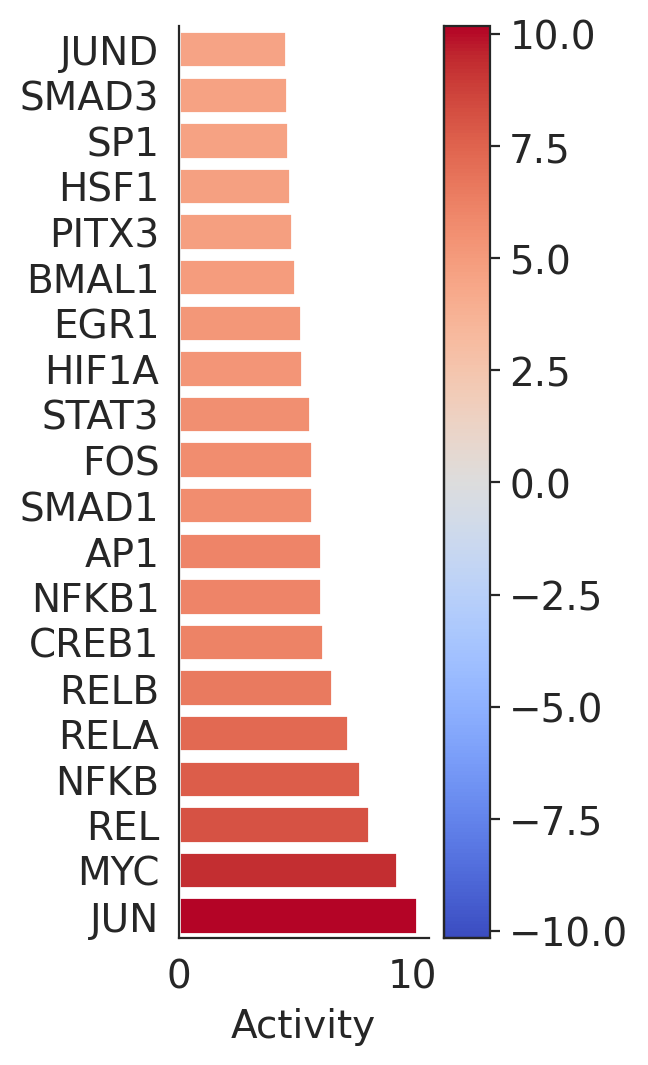

In [46]:
with rc_context({'figure.figsize': (5, 7)}):
    dc.plot_barplot(
        acts=tf_acts,
        contrast='PPP neutrophil',
        top=20,
        vertical=True,
        figsize=(2, 6),
        return_fig=True,
    )
    sns.despine()
    plt.savefig('figures/fig4_2/bulk_neutrophil_tf_activity.pdf', bbox_inches='tight')

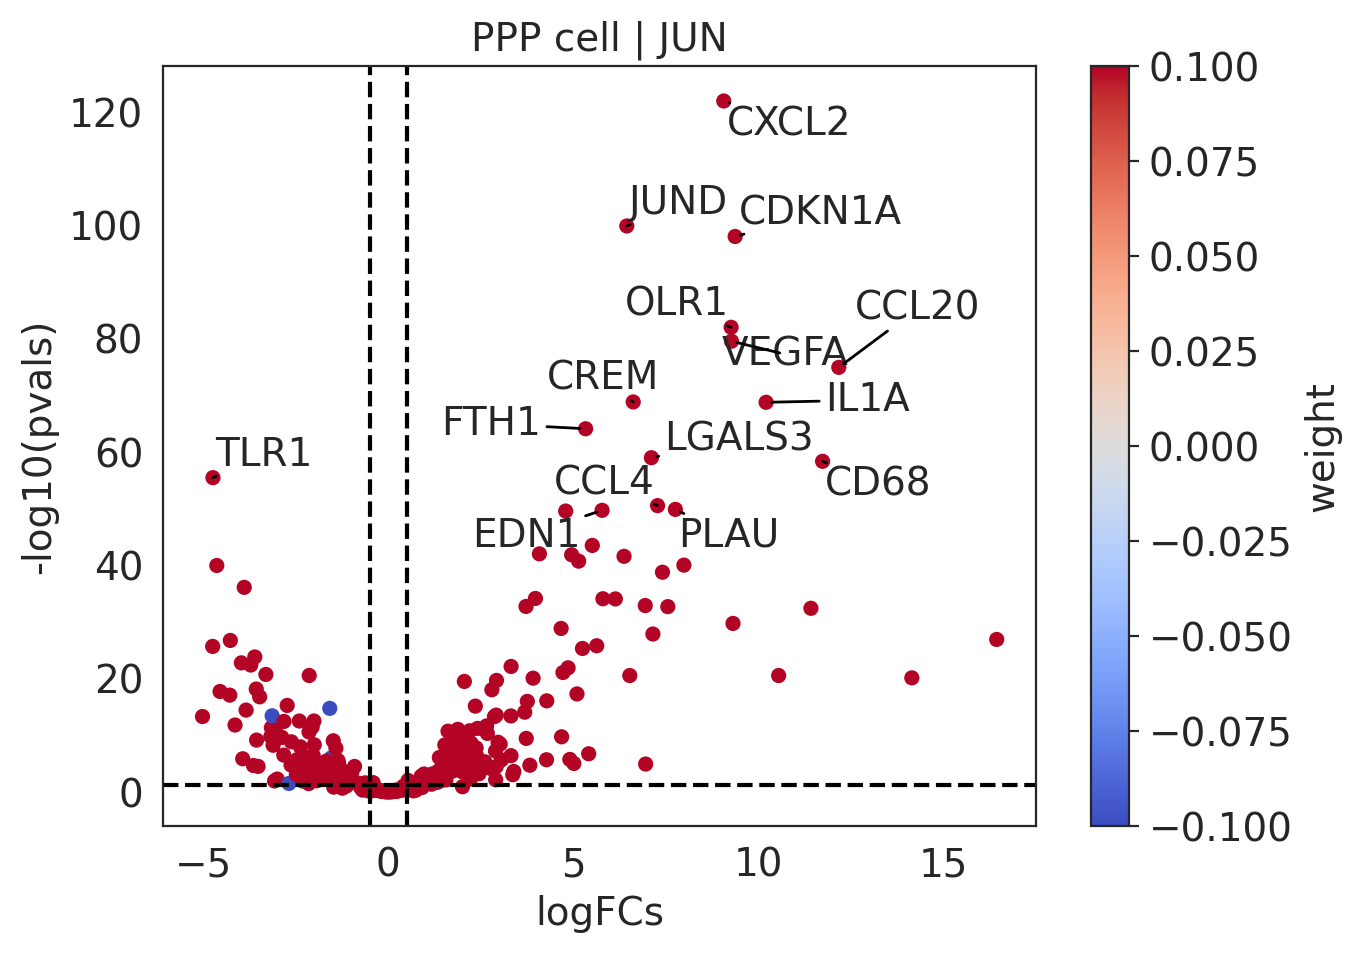

In [47]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'PPP cell'})
pvals = results_df[['padj']].T.rename(index={'padj': 'PPP cell'})

# Plot
with rc_context({'figure.figsize': (5, 7)}):
    dc.plot_volcano(
        logFCs=logFCs,
        pvals=pvals,
        contrast='PPP cell',
        name='JUN',
        net=collectri,
        top=15,
        sign_thr=0.05,
        lFCs_thr=0.5,
        return_fig=True,
    )
    plt.savefig('figures/fig4_2/PPP_neutrophil_jun_volcano.pdf', bbox_inches='tight')
    plt.show

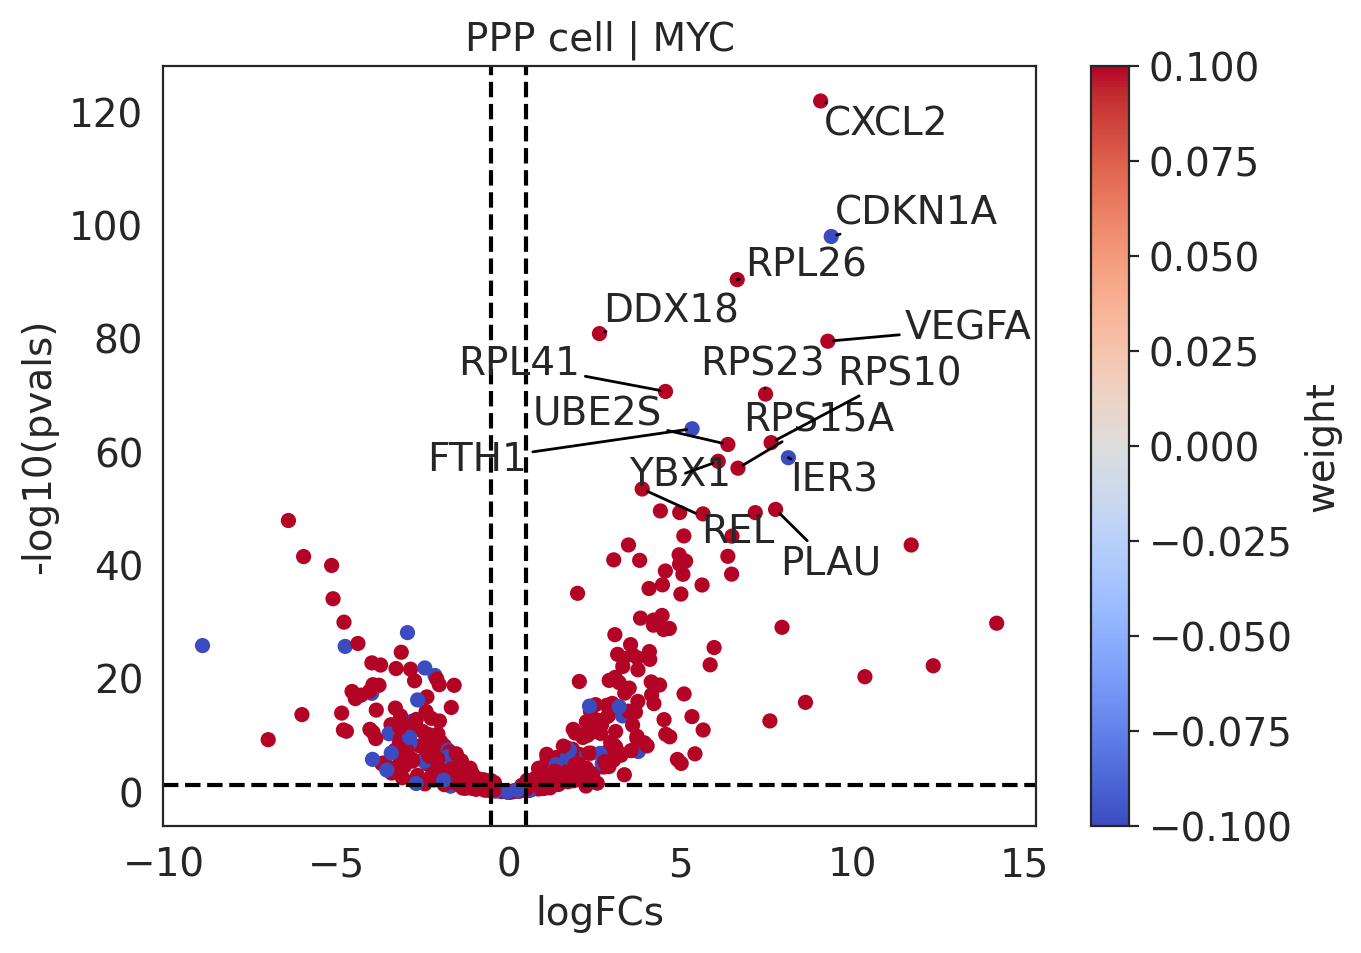

In [48]:
with rc_context({'figure.figsize': (5, 7)}):
    dc.plot_volcano(
        logFCs=logFCs,
        pvals=pvals,
        contrast='PPP cell',
        name='MYC',
        net=collectri,
        top=15,
        sign_thr=0.05,
        lFCs_thr=0.5,
        return_fig=True,
    )
    plt.savefig('figures/fig4_2/PPP_neutrophil_myc_volcano.pdf', bbox_inches='tight')
    plt.show

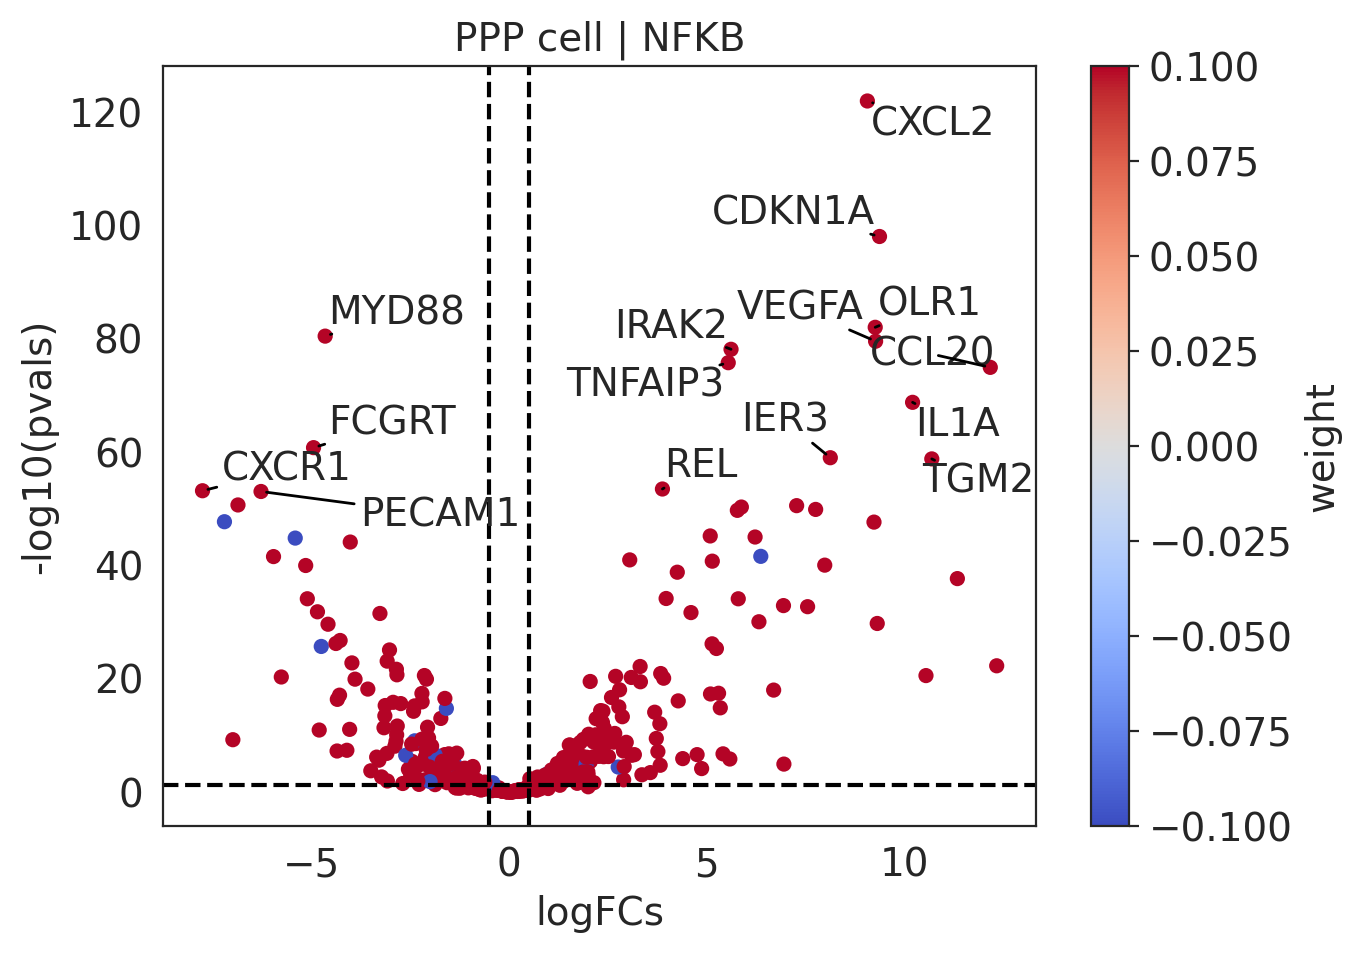

In [49]:
with rc_context({'figure.figsize': (5, 7)}):
    dc.plot_volcano(
        logFCs=logFCs,
        pvals=pvals,
        contrast='PPP cell',
        name='NFKB',
        net=collectri,
        top=15,
        sign_thr=0.05,
        lFCs_thr=0.5,
        return_fig=True,
    )
    plt.savefig('figures/fig4_2/PPP_neutrophil_nfkb_volcano.pdf', bbox_inches='tight')
    plt.show

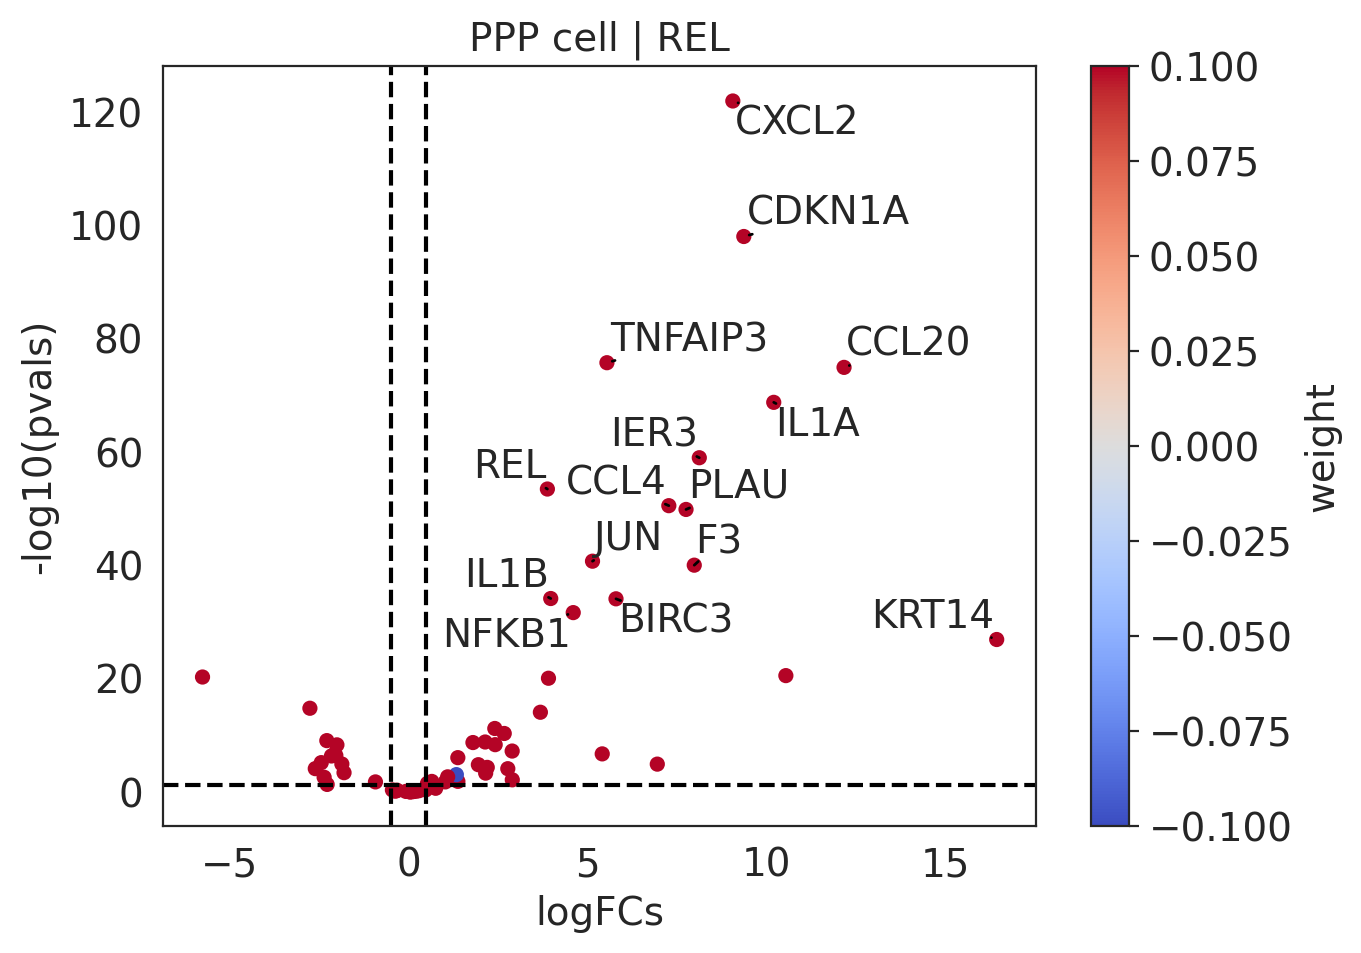

In [50]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'PPP cell'})
pvals = results_df[['padj']].T.rename(index={'padj': 'PPP cell'})

# Plot
with rc_context({'figure.figsize': (5, 7)}):
    dc.plot_volcano(
        logFCs=logFCs,
        pvals=pvals,
        contrast='PPP cell',
        name='REL',
        net=collectri,
        top=15,
        sign_thr=0.05,
        lFCs_thr=0.5,
        return_fig=True,
    )
    plt.savefig('figures/fig4_2/PPP_neutrophil_rel_volcano.pdf', bbox_inches='tight')
    plt.show

### CCL, CXCL

In [51]:
pdata_neut_merge
pdata_neut_merge.layers['counts'] = pdata_neut_merge.X.copy()

sc.pp.normalize_total(pdata_neut_merge, target_sum=1e4)
sc.pp.log1p(pdata_neut_merge)

normalizing counts per cell
    finished (0:00:00)


In [52]:
pdata_neut_merge.obs

,group
PPP_P16_foot_10X_PPP neutrophil,PPP
PPP_P17_palm_10X_PPP neutrophil,PPP
PPP_P36_foot_10X_PPP neutrophil,PPP
PPP_P37_palm_10X_PPP neutrophil,PPP
PPP_P38_palm_10X_PPP neutrophil,PPP
PPP_P39_palm_10X_PPP neutrophil,PPP
PPP_P40_palm_10X_PPP neutrophil,PPP
ERR7425289,HC
ERR7425279,HC
ERR7425260,HC


In [53]:
gene_list = ['CCL3', 'CCL3L3', 'CCL2', 'CCL20', 'CXCL1', 'CXCL2', 'CXCL8']
for gene in gene_list:
    pdata_neut_merge.obs[f"{gene}_exp"] = pdata_neut_merge[:, gene].X.toarray().flatten()

HC vs. PPP: Mann-Whitney-Wilcoxon test two-sided, P_val:3.108e-04 U_stat=0.000e+00


/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


HC vs. PPP: Mann-Whitney-Wilcoxon test two-sided, P_val:3.108e-04 U_stat=0.000e+00
HC vs. PPP: Mann-Whitney-Wilcoxon test two-sided, P_val:2.051e-02 U_stat=8.000e+00
HC vs. PPP: Mann-Whitney-Wilcoxon test two-sided, P_val:1.403e-03 U_stat=0.000e+00


/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


HC vs. PPP: Mann-Whitney-Wilcoxon test two-sided, P_val:3.108e-04 U_stat=0.000e+00
HC vs. PPP: Mann-Whitney-Wilcoxon test two-sided, P_val:3.108e-04 U_stat=0.000e+00
HC vs. PPP: Mann-Whitney-Wilcoxon test two-sided, P_val:3.108e-04 U_stat=0.000e+00


/home/wu/mambaforge/envs/scanpy/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


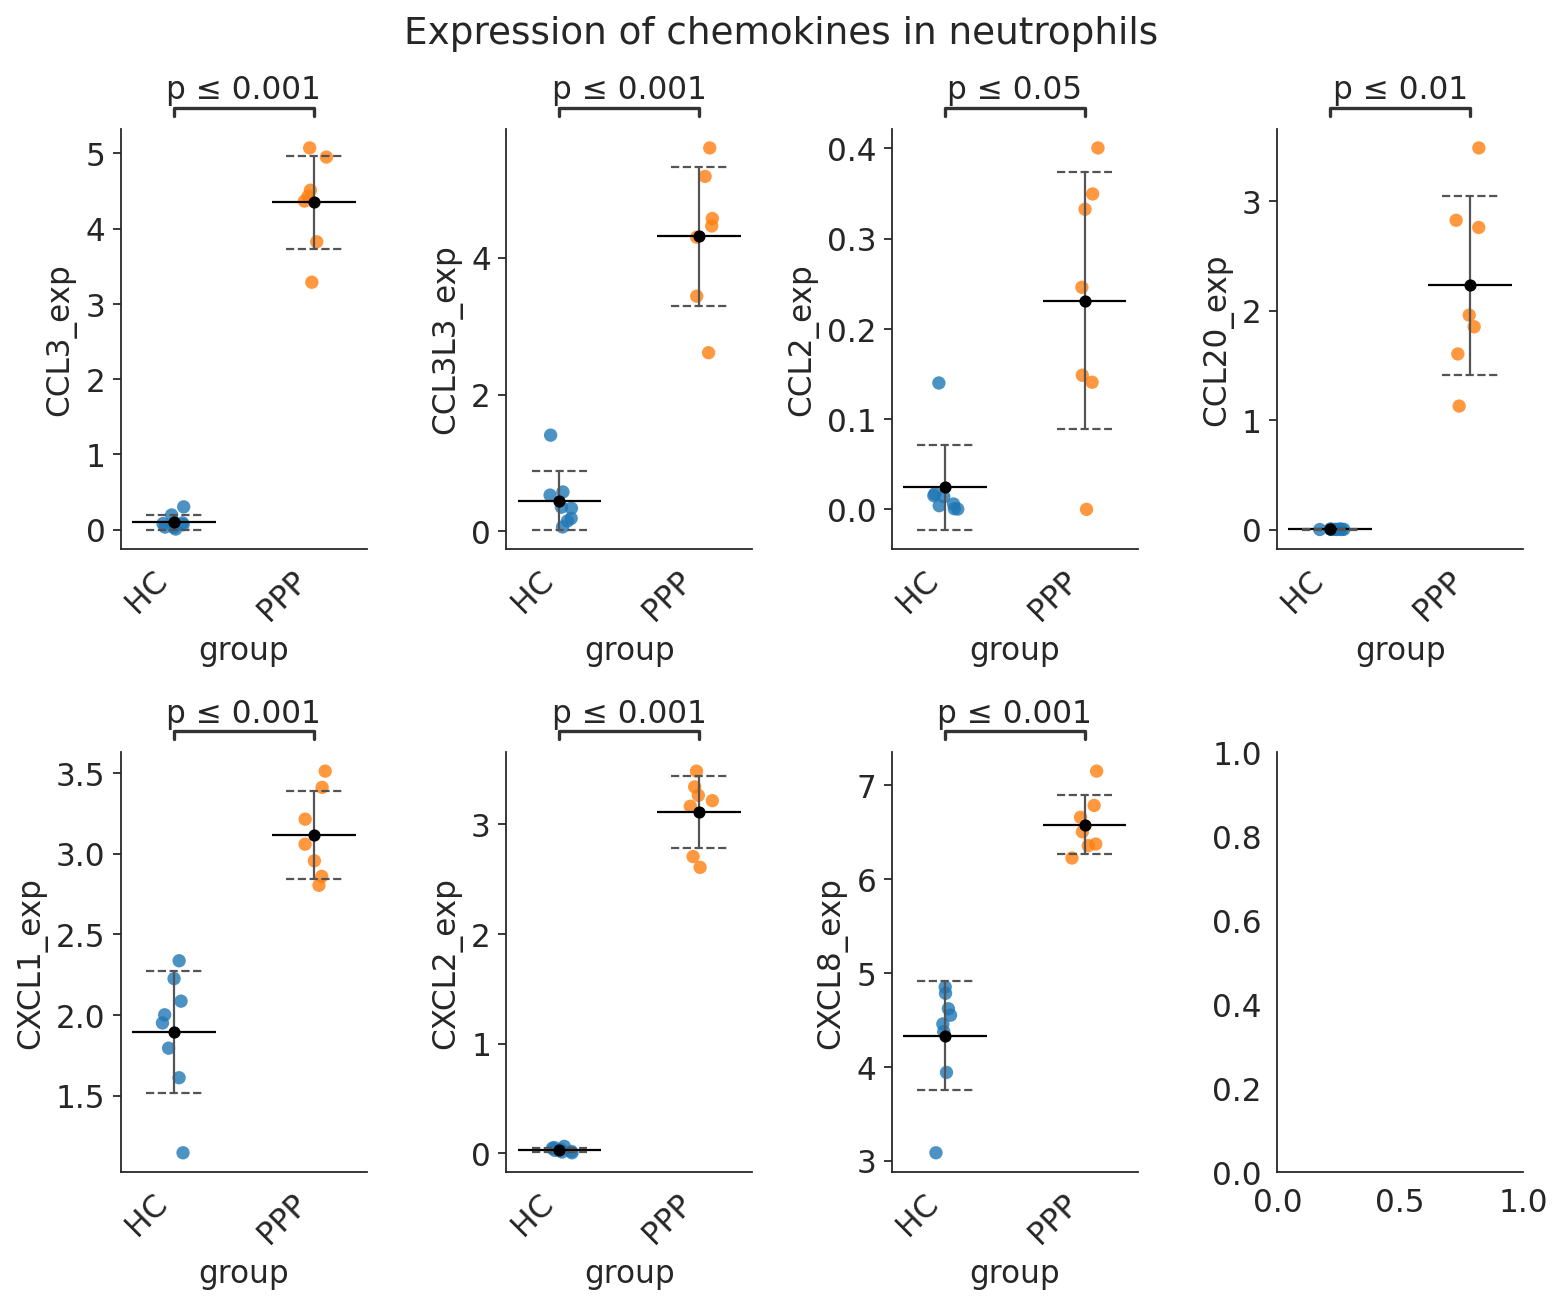

In [54]:
order = ['HC', 'PPP']
pairs = [('HC', 'PPP')]

def plot_es(df, col_list, suptitle, path=None):
    nrows = np.ceil(len(col_list) / 4).astype(int)
    fig, ax = plt.subplots(nrows=nrows, ncols=4, figsize=(10, 4*nrows))
    
    for i, col in enumerate(col_list):
        col = f"{col}_exp"
        df[col] = df[col].astype(float)
        lesion_sd = df[df['group'] == 'PPP'][col].std()
        lesion_mean = df[df['group'] == 'PPP'][col].mean()
        normal_sd = df[df['group'] == 'HC'][col].std()
        normal_mean = df[df['group'] == 'HC'][col].mean()

        sns.stripplot(data=df, x='group', y=col, palette='tab10', size=6, jitter=True, alpha=0.8, order=['HC', 'PPP'],
                           ax=ax[i//4, i%4])

        ax[i//4, i%4].hlines(lesion_mean, 0.7, 1.3, color='black', linestyle='-', lw=1, zorder=10)
        ax[i//4, i%4].hlines(normal_mean, -0.3, 0.3, color='black', linestyle='-', lw=1, zorder=10)
        ax[i//4, i%4].hlines(lesion_mean + lesion_sd, 0.8, 1.2, color='#545457', linestyle='--', lw=1, zorder=10)
        ax[i//4, i%4].hlines(lesion_mean - lesion_sd, 0.8, 1.2, color='#545457', linestyle='--', lw=1, zorder=10)
        ax[i//4, i%4].hlines(normal_mean + normal_sd, -0.2, 0.2, color='#545457', linestyle='--', lw=1, zorder=10)
        ax[i//4, i%4].hlines(normal_mean - normal_sd, -0.2, 0.2, color='#545457', linestyle='--', lw=1, zorder=10)
        ax[i//4, i%4].vlines(1, lesion_mean - lesion_sd, lesion_mean + lesion_sd, color='#545457', linestyle='-', lw=1, zorder=10)
        ax[i//4, i%4].vlines(0, normal_mean - normal_sd, normal_mean + normal_sd, color='#545457', linestyle='-', lw=1, zorder=10)
        
        ax[i//4, i%4].scatter([0, 1], [normal_mean, lesion_mean], color='black', s=20, zorder=10)
        ax[i//4, i%4].yaxis.set_ticks_position('left')

        ax[i//4, i%4].set_xticklabels(ax[i//4, i%4].get_xticklabels(), rotation=45, horizontalalignment='right')
        annotator = Annotator(ax[i//4, i%4], pairs=pairs, data=df, x='group', y=col, order=order)
        annotator.configure(test="Mann-Whitney", text_format='simple', loc='outside', show_test_name=False)
        annotator.apply_and_annotate()
    
    sns.despine()
    fig.tight_layout()
    fig.suptitle(suptitle, y=1.02)
    if path:
        plt.savefig(path, bbox_inches='tight')

plot_es(pdata_neut_merge.obs, gene_list, 'Expression of chemokines in neutrophils',
        path='figures/fig4_2/PPP_neutrophil_chmokines_bulk.pdf')